   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 21.0 MB/s eta 0:00:00
No 'data/' folder with .wav files found. The code will use FALLBACK synthetic data for a runnable demo.
Generating synthetic dataset (fallback) — this demonstratse the pipeline.
Classes: [np.str_('angry'), np.str_('happy'), np.str_('sad')]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 40, 174, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 20, 87, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 87, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10, 43, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 13760)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       880,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 885,827 (3.38 MB)

 Trainable params: 885,763 (3.38 MB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/12
12/12 - 5s - 431ms/step - accuracy: 0.4222 - loss: 2.8175 - val_accuracy: 0.4250 - val_loss: 1.9915
Epoch 2/12
12/12 - 4s - 322ms/step - accuracy: 0.6167 - loss: 1.0385 - val_accuracy: 0.4750 - val_loss: 1.7887
Epoch 3/12
12/12 - 2s - 136ms/step - accuracy: 0.6806 - loss: 0.7113 - val_accuracy: 0.5250 - val_loss: 1.4841
Epoch 4/12
12/12 - 3s - 213ms/step - accuracy: 0.7417 - loss: 0.5753 - val_accuracy: 0.4750 - val_loss: 1.3342
Epoch 5/12
12/12 - 4s - 300ms/step - accuracy: 0.7750 - loss: 0.5232 - val_accuracy: 0.5500 - val_loss: 1.1275
Epoch 6/12
12/12 - 4s - 334ms/step - accuracy: 0.8139 - loss: 0.4472 - val_accuracy: 0.6000 - val_loss: 0.9294
Epoch 7/12
12/12 - 3s - 216ms/step - accuracy: 0.8278 - loss: 0.3646 - val_accuracy: 0.5500 - val_loss: 0.9096
Epoch 8/12
12/12 - 2s - 135ms/step - accuracy: 0.8778 - loss: 0.2941 - val_accuracy: 0.5250 - val_loss: 0.9205
Epoch 9/12
12/12 - 2s - 139ms/step - accuracy: 0.8889 - loss: 0.2630 - val_accuracy: 0.5750 - val_loss: 1.0212
E

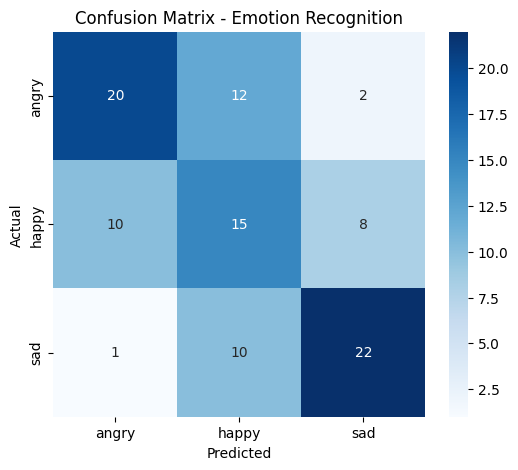

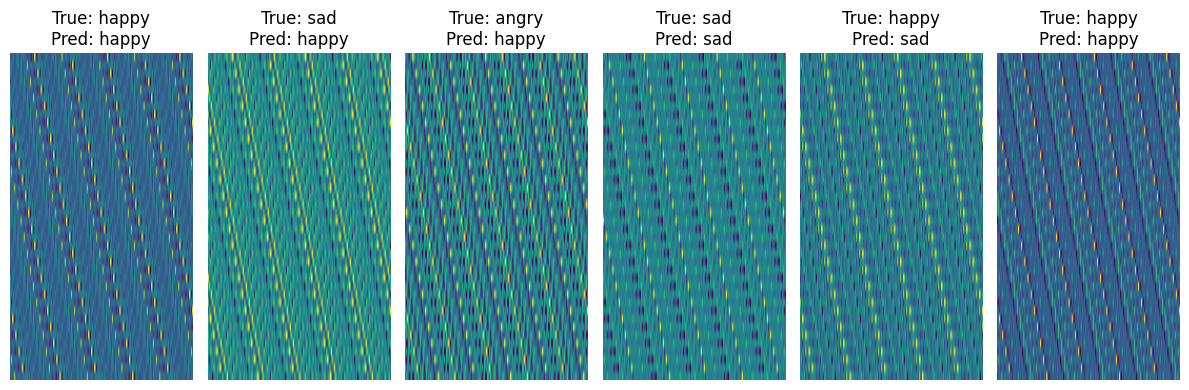

In [1]:
# ===== Task 2: Emotion Recognition from Speech (Robust single-cell) =====
# Paste in Google Colab or Jupyter and run.
# If you have real audio files, put them in a folder named "data/" with filenames like "happy_01.wav", "sad_02.wav"

# 1) Install required packages (resampy included)
!pip install resampy librosa soundfile --quiet

# 2) Imports
import os, glob, math
import numpy as np
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras import layers, models, utils, callbacks
import tensorflow as tf

# 3) Feature extraction parameters
N_MFCC = 40
MAX_PAD_LEN = 174   # fixed number of frames (tweak if needed)

def extract_mfcc(file_path, n_mfcc=N_MFCC, max_len=MAX_PAD_LEN):
    try:
        y, sr = librosa.load(file_path, sr=None)   # preserve native sr
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        # pad / truncate to max_len
        if mfcc.shape[1] < max_len:
            pad_width = max_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0,0),(0,pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_len]
        return mfcc
    except Exception as e:
        # if any file fails, return None
        print("Failed to parse:", os.path.basename(file_path), str(e).split('\n')[0])
        return None

# 4) Try to load real audio files from 'data/' folder (user-provided)
data_folder = "data"
audio_files = []
if os.path.isdir(data_folder):
    # find wav files
    audio_files = glob.glob(os.path.join(data_folder, "*.wav"))
    print("Found local audio files:", len(audio_files))

# 5) If no local files, try to download a small demo repo (optional) OR fallback
if len(audio_files) == 0:
    print("No 'data/' folder with .wav files found. The code will use FALLBACK synthetic data for a runnable demo.")
    use_fallback = True
else:
    use_fallback = False

# 6) If using real files: extract features & labels
if not use_fallback:
    X_list = []
    y_list = []
    for f in audio_files:
        mf = extract_mfcc(f)
        if mf is not None:
            X_list.append(mf)
            # label assumed from filename prefix before underscore: e.g., happy_01.wav
            label = os.path.basename(f).split("_")[0]
            y_list.append(label)
    if len(X_list) == 0:
        print("No usable audio features extracted from local files. Switching to fallback.")
        use_fallback = True
    else:
        X = np.stack(X_list)   # shape -> (n_samples, n_mfcc, max_len)
        y = np.array(y_list)

# 7) Fallback synthetic dataset (if no real audio)
if use_fallback:
    from sklearn.datasets import make_classification
    print("Generating synthetic dataset (fallback) — this demonstratse the pipeline.")
    Xs, ys = make_classification(n_samples=500, n_features=N_MFCC*MAX_PAD_LEN//100, n_informative=20, n_classes=3, random_state=42)
    # reshape synthetic to match CNN input dims (n_mfcc, time) roughly
    # We'll make (n_mfcc, max_len) by repeating / trimming
    n_samples = Xs.shape[0]
    # create 2D arrays by reshaping/repeating
    X = np.zeros((n_samples, N_MFCC, MAX_PAD_LEN))
    for i in range(n_samples):
        vec = np.tile(Xs[i], int(math.ceil((N_MFCC*MAX_PAD_LEN)/(Xs.shape[1]))))[:N_MFCC*MAX_PAD_LEN]
        X[i] = vec.reshape((N_MFCC, MAX_PAD_LEN))
    # create simple textual labels for 3 classes
    label_names = ['happy','sad','angry']
    y = np.array([label_names[val % 3] for val in ys])

# 8) Encode labels and prepare data for CNN
le = LabelEncoder()
y_enc = le.fit_transform(y)  # integers
num_classes = len(le.classes_)
print("Classes:", list(le.classes_))

# expand dims for channel (CNN expects channels)
X = X.astype('float32')
X = X[..., np.newaxis]   # shape -> (samples, n_mfcc, max_len, 1)

# 9) Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, stratify=y_enc, random_state=42)

# 10) Build a small CNN model (fast)
input_shape = X_train.shape[1:]
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(16, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# 11) Train model (fast: small epochs). If dataset is large, increase epochs.
es = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.1, epochs=12, batch_size=32, callbacks=[es], verbose=2)

# 12) Evaluate & outputs
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {acc:.4f}")

y_prob = model.predict(X_test)
y_pred = np.argmax(y_prob, axis=1)

# Ensure labels array for classification_report includes all classes
all_classes = np.arange(num_classes)
class_names = le.classes_

from sklearn.metrics import classification_report, confusion_matrix
print("\n📄 Classification Report:\n")
print(classification_report(y_test, y_pred, labels=all_classes, target_names=class_names, zero_division=0))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred, labels=all_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Emotion Recognition")
plt.show()

# 13) (Optional) Show a few test samples with predicted label
n_show = min(6, X_test.shape[0])
plt.figure(figsize=(12,4))
for i in range(n_show):
    ax = plt.subplot(1, n_show, i+1)
    img = X_test[i].squeeze()
    plt.imshow(img, aspect='auto', origin='lower')
    plt.title(f"True: {le.inverse_transform([y_test[i]])[0]}\nPred: {le.inverse_transform([y_pred[i]])[0]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
